In [28]:
import os, datetime
from collections import namedtuple
from urllib.parse import urlencode

import tensorflow as tf
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gym

import tf_util, load_policy

## Environments

In [2]:
envs = [f.split('.')[0] for f in os.listdir('./experts')]

## Utility Class

In [57]:
class ReplayBuffer:
    def __init__(self):
        self.s = []
        self.a = []
        self.r = []
    
    def add(self, s, a, r):
        self.s.append(s)
        self.a.append(a)
        self.r.append(r)

    def get_batch(self, batch_size):
        for i in range(0, len(self.s), batch_size):
            yield self.s[i:i+batch_size], self.a[i:i+batch_size], self.r[i:i+batch_size]
    
    def concat(self, buf):
        self.s += buf.s
        self.a += buf.a
        self.r += buf.r
        
        return self

## Agents

In [64]:
class ExpertAgent:
    def __init__(self, envname):
        sess = tf.Session()
        with sess.as_default():
            tf_util.initialize()
            self.get_expert_policy = load_policy.load_policy('experts/{}.pkl'.format(envname))

        self.sess = sess
        self.env = gym.make(envname)
    
    def get_action(self, state):
        with self.sess.as_default():
            return self.get_expert_policy(state)
    
    def run_episode(self, max_iter=1):
        maxstep = self.env.spec.max_episode_steps
        
        buf = ReplayBuffer()
        
        for _ in range(max_iter):
            s = self.env.reset()
            
            for _ in range(maxstep):
                a = self.get_action([s])[0]
                s_, r, done, _ = self.env.step(a)
                buf.add(s, a, r)
                s = s_

                if done:
                    break
            
        return buf
    
    def close(self):
        self.sess.close()

In [60]:
class Agent:
    def __init__(self,
                 envname,
                 name='behavior_clone',
                 learning_rate=0.001,
                 logdir='tb_log'):
        # Create environments
        env = gym.make(envname)
        s_size = env.observation_space.shape
        a_size = env.action_space.shape
        
        # Create graph
        graph = tf.Graph()

        with graph.as_default():
            s_pl = tf.placeholder(dtype=tf.float32, shape=(None, *s_size), name='state')
            a_pl = tf.placeholder(dtype=tf.float32, shape=(None, *a_size), name='target_action')

            with tf.variable_scope('my_policy'):
                hidden1 = tf.layers.dense(s_pl, 200, activation=tf.nn.relu, name='hidden1')
                hidden2 = tf.layers.dense(hidden1, 100, activation=tf.nn.relu, name='hidden2')

                a_logit = tf.layers.dense(hidden2, a_size[0], activation=tf.tanh, name='logit')

            with tf.variable_scope('training'):
                loss = tf.losses.mean_squared_error(a_pl, a_logit, reduction=tf.losses.Reduction.MEAN)
                train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
                tf.summary.scalar('loss/MSE', loss)

            summary_merged = tf.summary.merge_all()
        
        # Initialize
        sess = tf.Session(graph=graph)
        
        var_list = graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        sess.run(tf.variables_initializer(var_list))

        ts = datetime.datetime.now()
        logpath = '{}/{}/{}'.format(logdir, name, ts)
        writer = tf.summary.FileWriter(logpath, graph)
        
        # Tensorflow-related
        self.graph = graph
        self.sess = sess
        self.s_pl = s_pl
        self.a_pl = a_pl
        self.a_logit = a_logit
        self.train_op = train_op
        self.writer = writer
        self.summary_merged = summary_merged
        
        self.name = name
        self.ts = ts
        self.logpath = logpath
        
        self.env = env
        self.envname = envname
        
        self.n_iter = 0
        self.n_train = 0
    
    def get_action(self, s):
        return self.sess.run(self.a_logit, feed_dict={self.s_pl: s})
    
    def run_episode(self, max_iter=1):
        maxstep = self.env.spec.max_episode_steps
        buf = ReplayBuffer()
        
        for _ in range(max_iter):
            s = self.env.reset()
            reward = 0
            
            for n_step in range(maxstep):
                a = self.get_action([s])
                s_, r, done, _ = self.env.step(a)
                
                reward += r
                buf.add(s, a, r)

                s = s_

                if done:
                    break

            reward_summary = tf.Summary(value=[tf.Summary.Value(tag='reward', simple_value=reward)])
            self.writer.add_summary(reward_summary, self.n_iter)
            self.n_iter += 1
        
        self.writer.flush()
        
        return buf
    
    def train(self, s_batch, a_target):
        summary, _ = self.sess.run([self.summary_merged, self.train_op],
                                   feed_dict={self.s_pl: s_batch, self.a_pl: a_target})
        self.writer.add_summary(summary, self.n_train)
        self.writer.flush()
        self.n_train += 1
    
    def tensorboard_scalar_url(self, tag):
        tb_url = 'http://localhost:6006/data/plugin/scalars/scalars'
        query = {
            'run': '{}/{}'.format(self.name, self.ts),
            'tag': tag,
            'format': 'csv'
        }
        
        return '{}?{}'.format(tb_url, urlencode(query))
    
    def plot_stats(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
        fig.suptitle(self.name, fontsize=16)
        
        reward_df = pd.read_csv(self.tensorboard_scalar_url('reward'))
        loss_df = pd.read_csv(self.tensorboard_scalar_url('training/loss/MSE'))
        
        reward_ax = reward_df.plot(x='Step', y='Value', title='reward', ax=axes[0])
        loss_ax = loss_df.plot(x='Step', y='Value', title='loss/MSE', ax=axes[1])
        
        return reward_ax, loss_ax
    
    def get_rewards(self):
        return pd.read_csv(self.tensorboard_scalar_url('reward'), usecols=['Value']).Value.values
    
    def close(self):
        self.writer.close()
        self.sess.close()

In [55]:
batch_size = 64
maxiter = 20

## Behavior Cloning

In [65]:
def fit_behavior_cloning_agent(envname):
    agent = Agent(envname, name='behavior_clone_' + envname)
    expert = ExpertAgent(envname)
    
    target_data = expert.run_episode(maxiter)
    
    for s_batch, a_batch, _ in target_data.get_batch(batch_size):
        agent.train(s_batch, a_batch)
    
    return agent, expert

In [66]:
bc_agents = [fit_behavior_cloning_agent(envname) for envname in envs]
experts_rewards = []
for a, e in bc_agents:
    a.run_episode(maxiter)
    experts_rewards.append([sum(e.run_episode().r) for _ in range(maxiter)])
    
    a.close()
    e.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
obs (1, 11) (1, 11)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
obs (1, 11) (1, 11)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. P

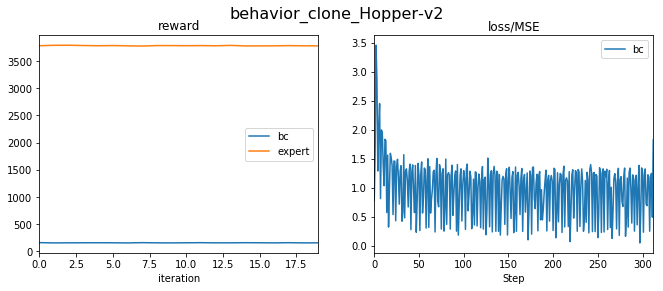

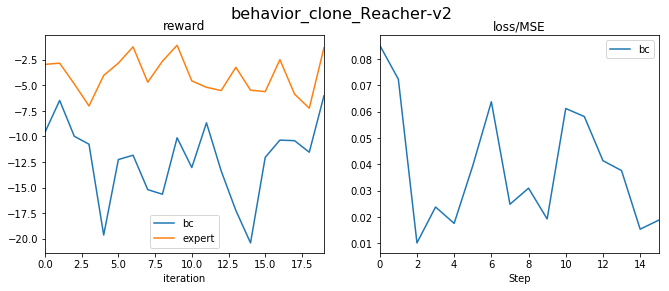

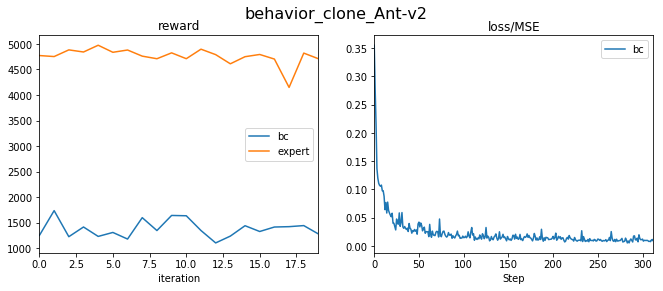

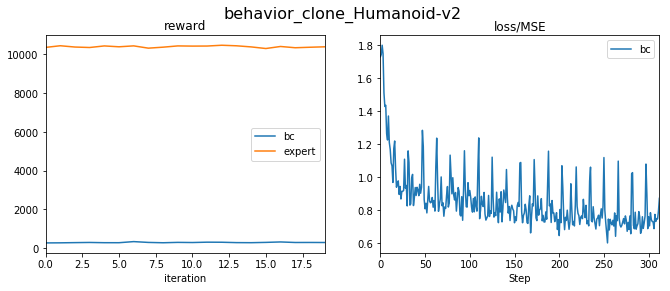

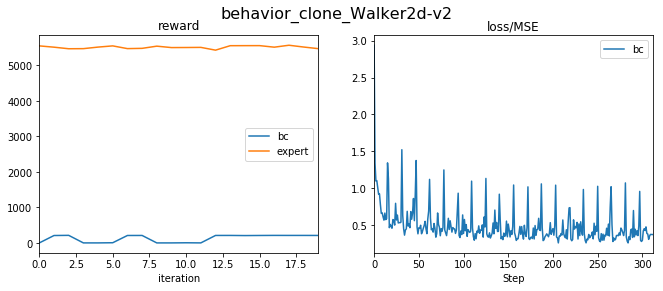

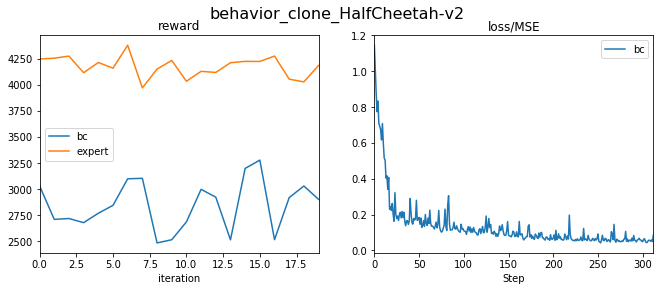

In [67]:
for (a, _), exp_rewards in zip(bc_agents, experts_rewards):
    reward_ax, loss_ax = a.plot_stats()
    
    reward_ax.plot(np.arange(len(exp_rewards)), exp_rewards)
    reward_ax.set_xlabel('iteration')
    reward_ax.legend(['bc', 'expert'])
    
    loss_ax.legend(['bc'])

In [68]:
data = { 
    'bc_mean': [agent.get_rewards().mean() for agent, _ in bc_agents],
    'bc_std': [agent.get_rewards().std() for agent, _ in bc_agents],
    'expert_mean': [np.array(exp_rewards).mean() for exp_rewards in experts_rewards],
    'expert_std': [np.array(exp_rewards).std() for exp_rewards in experts_rewards],
}

indices = [agent.envname for agent, _ in bc_agents]

df = pd.DataFrame(data, indices)
df

,bc_mean,bc_std,expert_mean,expert_std
Hopper-v2,159.849384,1.497835,3778.880039,3.741895
Reacher-v2,-12.230838,3.738930,-4.034826,1.801399
Ant-v2,1379.483905,164.196325,4758.044470,161.768925
Humanoid-v2,297.580145,15.388732,10398.757680,44.619544
Walker2d-v2,126.902422,102.368459,5512.867166,36.966960
HalfCheetah-v2,2844.368640,234.615522,4172.684385,98.105764


## DAgger

In [56]:
def fit_dagger_agent(envname):
    agent = Agent(envname, name='dagger_' + envname)
    expert = ExpertAgent(envname)
    
    buf = ReplayBuffer()
    for _ in range(maxiter):
        episode_buf = agent.run_episode()
        buf.concat(episode_buf)

        for s_batch, _, _ in buf.get_batch(batch_size):
            expert_action = expert.get_action(s_batch)
            agent.train(s_batch, expert_action)
    
    agent.close()
    
    return agent, expert

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
obs (1, 11) (1, 11)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
obs (1, 11) (1, 11)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. P

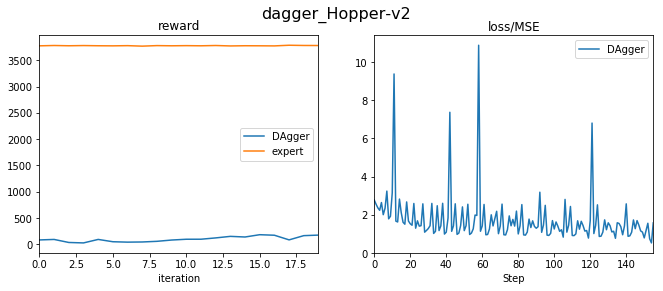

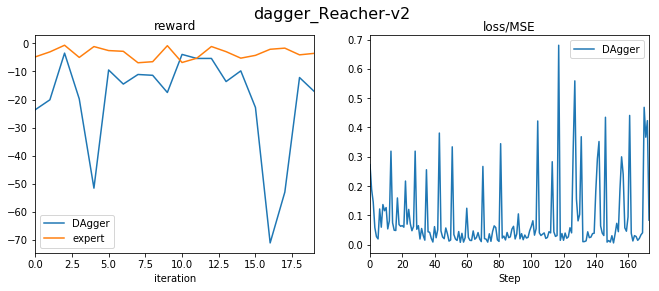

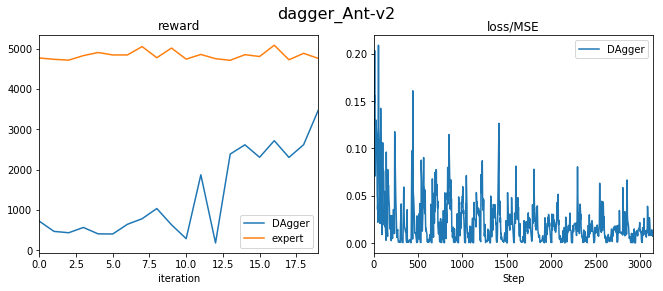

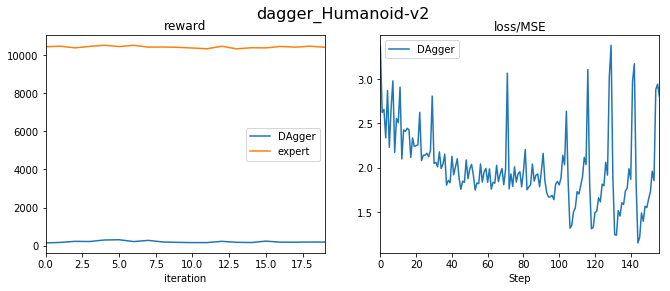

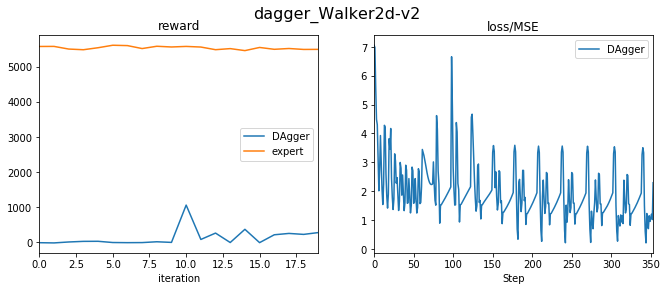

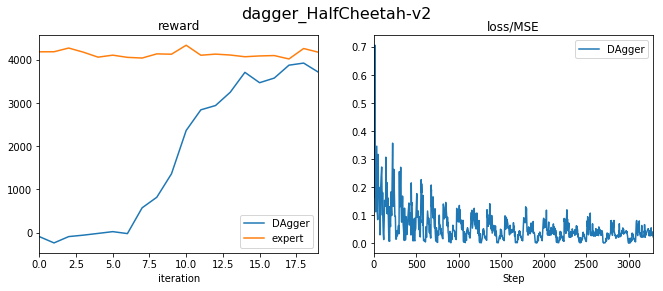

In [61]:
dagger_agents = [fit_dagger_agent(envname) for envname in envs]
for a, e in dagger_agents:
    exp_rewards = [sum(e.run_episode().r) for _ in range(maxiter)]
    reward_ax, loss_ax = a.plot_stats()
    
    reward_ax.plot(np.arange(len(exp_rewards)), exp_rewards)
    reward_ax.set_xlabel('iteration')
    reward_ax.legend(['DAgger', 'expert'])
    
    loss_ax.legend(['DAgger'])